In [1]:
import os
import numpy as np
import pandas as pd

import skimage.io as skio
import skimage.transform as skit
import skimage.morphology as skim
from sklearn.base import clone

import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-07-12 18:11:43,629 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [3]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [4]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([1, 1.25, 2, 0.75], index=subjectdata.index)
subjectdata

,second_sight_id,implant_x,implant_y,implant_rot,loc_od_x,loc_od_y,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S1,TB,-406,-162,-0.698,17.7,1.68,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,1.00
S2,12-005,-1860,-615,-0.510,16.2,1.43,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,1.25
S3,51-009,-139,-114,-0.714,14.5,2.09,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,2.00
S4,52-001,-1230,415,-0.457,15.9,1.96,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.75


In [5]:
subjects = subjectdata.index.sort_values()

In [6]:
X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))
Xy = pd.concat((X, y.drop(columns='electrode')), axis=1)

In [7]:
Xmu, ymu = argus_shapes.calc_mean_images(X, y, thresh=False, max_area=np.inf)
Xymu = pd.concat((Xmu, ymu.drop(columns='electrode')), axis=1)

In [8]:
assert Xy.electrode.unique().sort() == Xymu.electrode.unique().sort()

In [9]:
best_worst = pd.DataFrame([
    {'subject': 'S1', 'best': 'D2', 'worst': 'D1'},
    {'subject': 'S2', 'best': 'C10', 'worst': 'F2'},
    {'subject': 'S3', 'best': 'E1', 'worst': 'C10'},
    {'subject': 'S4', 'best': 'F9', 'worst': 'C4'}
]).set_index('subject')
best_worst

,best,worst
subject,,
S1,D2,D1
S2,C10,F2
S3,E1,C10
S4,F9,C4


In [10]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

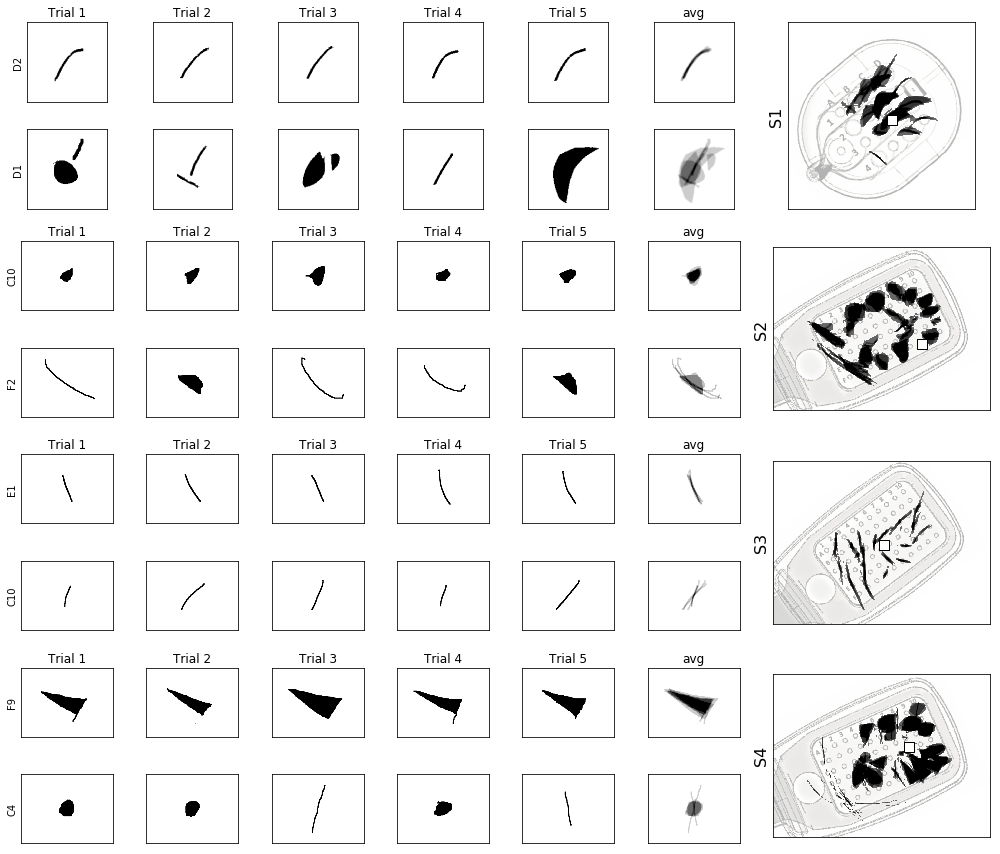

In [11]:
fig = plt.figure(figsize=(14, 3 * len(subjects)))
scale_trials = 2.5

for s, subject in enumerate(subjects):
    ax1 = plt.subplot2grid((2 * len(subjects), 8), (s * 2, 6), rowspan=2, colspan=2)
    plot_phosphenes_on_array(ax1, subject, Xymu, subjectdata)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel(subject, fontsize=16)
    for r, bw in enumerate(['best', 'worst']):
        electrode = best_worst.loc[subject, bw]
        idx_drawings = np.logical_and(Xy.subject == subject, Xy.electrode == electrode)
        for c, (_, drawing) in enumerate(Xy[idx_drawings].iterrows()):
            ax2 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, c))
            img_th = argus_shapes.imgproc.get_thresholded_image(drawing['image'])
            img_th = argus_shapes.imgproc.center_phosphene(img_th)
            img_th = argus_shapes.imgproc.scale_phosphene(img_th, scale_trials)
            ax2.imshow(1 - img_th, cmap='gray')
            ax2.set_xticks([])
            ax2.set_yticks([])
            if c == 0:
                ax2.set_ylabel(electrode)
            if r == 0:
                ax2.set_title('Trial %d' % (c + 1))
        ax3 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, 5))
        idx_drawings = np.logical_and(Xymu.subject == subject, Xymu.electrode == electrode)
        img_avg = ymu.loc[idx_drawings, 'image'].values[0]
        img_avg = argus_shapes.imgproc.center_phosphene(img_avg)
        img_avg = argus_shapes.imgproc.scale_phosphene(img_avg, scale_trials)
        ax3.imshow(1 - img_avg, cmap='gray')
        if r == 0:
            ax3.set_title('avg')
        ax3.set_xticks([])
        ax3.set_yticks([])
fig.tight_layout()
fig.savefig('fig2-phosphene-shape.eps')
fig.savefig('fig2-phosphene-shape.png')